<a href="https://colab.research.google.com/github/raphateixeira/TE-Controle/blob/main/Identifica%C3%A7%C3%A3o_LSTM_MMA_LIT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Massa - mola - amortecedor:

O sistema massa, mola amortecedor é um sistema dinâmico clássico da engenharia mecânica, cuja equação diferencial resultante da aplicação das leis de Newton é dada por:

$$ m\frac{d^2y(t)}{dt^2} + b\frac{dy(t)}{dt} + ky(t) = u(t)$$

Sendo:
- $u(t)$ o sinal de entrada;
- $y(t)$ o sinal de saída;
- $t$ o tempo contínuo;
- $m$ a massa;
- $b$ o coeficiente de amortecimento;
- $k$ a constante da mola.


A EDO, linear e invariante no tempo (LIT), pode ser convertida para a função de transferência, dada por:

$$ H(s) = \frac{1}{ms^2 + bs + k}$$

Também é possível expressá-lo na forma de espaço de estados, ao se quebrar a EDO de segunda ordem em duas EDOs de primeira ordem. Isto é feito tomando como estados as variáveis $x_1(t) = y(t)$ (posição), $x_2(t) = v(t)$ (velocidade).

O modelo no espaço de estados é dado então por:

$$
\begin{align}
\dot{x}_1(t) &= x_2(t) \\
\dot{x}_2(t) &= -\frac{k}{m}x_1(t) -\frac{b}{m}x_2(t) + \frac{1}{m}u(t)
\end{align}
$$

Assim, pode-se definir um sistema massa mola amortecedor como uma função que recebe os estados, a entrada, os parâmetros e retorna a derivada dos estados, ou seja:

In [ ]:
def MMA(x,t,u, m, b, k):
  # Estados
  x1, x2 = x

  # Equações dinâmicas
  dx1 = x2
  dx2 = -(k/m)*x1 - (b/m)*x2 + (1/m)*u

  return [dx1, dx2]

# Geração de dados:

Uma vez definido o modelo, pode-se gerar dados de entrada e saída.

Inicialmente $u(t)$ é gerado como um sinal PRBS (pseudo random binary signal). Que pode ser emulado a partir de uma função de geração de sequência máxima `max_len_seq` do pacote scipy.

In [ ]:
# Geração do sinal PRBS:
import numpy as np
import tensorflow as tf
from scipy import signal as sg
u = np.kron(2*(sg.max_len_seq(9)[0]-0.5),np.ones(5))

Para gerar os dados de saída o modelo dinâmico (função python MMA) deve ser integrada numericamente, o que será realizado, passo a passo, pela função `odeint` do `scipy`.

In [ ]:
from scipy.integrate import odeint

N = len(u) # Número de amostras;
Ts = 2.0    # Período de amostragem;
m, b, k = 1.0, 0.9, 0.8  # Parâmetros do MMA
X = np.zeros((N,2))   # Inicializa estados.
for n in np.arange(0,N-1):
  X[n+1,:] = odeint(MMA, X[n,:], [0, Ts], args = (u[n],m,b,k))[1,:]

y = X[:,0] # A saída y é o primeiro estado (índice 0).
t = Ts*np.arange(0,N)

Os dados de entrada e saída são guardados em um dicionário pandas e apresentados:

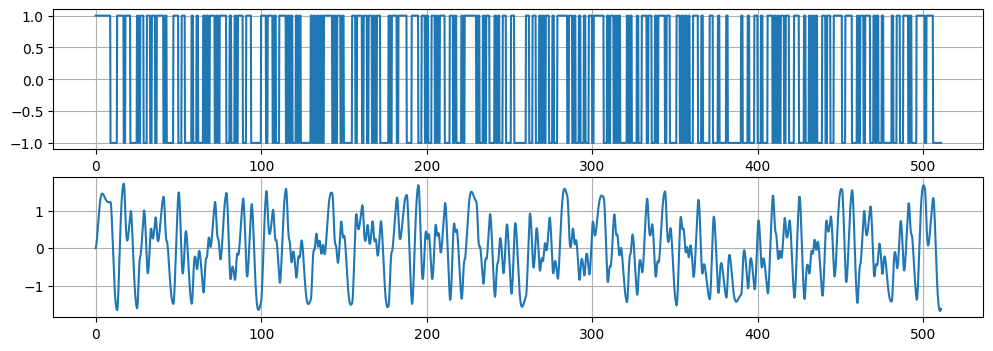

In [ ]:
# Guarda dados em um dicionário.
import matplotlib.pyplot as plt
import pandas as pd
Dados = pd.DataFrame(
        {"u": u,
         "y": y})

# Figura dos dados de entrada e saída:
plt.figure(figsize=(12,4))
plt.subplot(211)
plt.plot(t,u)
plt.grid()
plt.subplot(212)
plt.plot(t,y)
plt.grid()
plt.show()

## Identificação de sistemas: Modelo LSTM

A posse dos dados permite então considerar a recuperação do modelo do sistema a partir de uma RNN do tipo LSTM. Para isso é pertinente pré-processar os dados, para adequalos tanto a tarefa de aprendizagem, dimensionamento e adequação dimensional das amostras, de acordo com o padrão requerido por este tipo de RNA.

Inicialmente os dados são normalizados dentro de uma escala por meio da função `MinMaxScaler`do `scipy`. Isso é pertinente pois permite treinar a rede neurais com dados de valores modestos, o que pode facilitar o processo convergência dos valores dos parâmetros.

As funções de normalização para os dados de entrada e de saída são salvas por meio do pacote `joblib`.

O modelo que se busca será do tipo auto-regressivo com entrada. Para isso os dados de entrada $X_s$ são compostos pelos sinais $u$ e $y$, enquanto o sinal de saída é estabado em $Y_s$ a partir de $y$.

In [ ]:
# Normalização minmax:
from sklearn.preprocessing import MinMaxScaler
Escala1 = MinMaxScaler(feature_range=(-1,1))
Xs = Escala1.fit_transform(Dados[['u','y']])
Escala2 = MinMaxScaler(feature_range=(-1,1))
Ys = Escala2.fit_transform(Dados[['y']])
# Pode valer a pena uma leitura do pacote joblib: https://joblib.readthedocs.io/en/stable/

import joblib
joblib.dump(Escala1, 'Escala1.sav')
joblib.dump(Escala2, 'Escala2.sav')

['Escala2.sav']

Os sinais são divididos em amostras de entrada e de saída na amostra $N_i$, que é determinada a partir de um percentual dos dados desejado para identificação.

In [ ]:
percIdent = 0.5         # Percentual de amostras de identificação
Ni = int(N*percIdent)  # Número de amostras identificação
Xs_train = Xs[0:Ni]
Ys_train = Ys[0:Ni]
Xs_val = Xs[Ni:]
Ys_val = Ys[Ni:]
Xs_train

array([[ 1.        , -0.01434239],
       [ 1.        , -0.00321597],
       [ 1.        ,  0.02735698],
       ...,
       [-1.        , -0.05629364],
       [-1.        , -0.16640107],
       [-1.        , -0.27553367]])

Procede-se então com a geração dos padrões de entrada e saída a partir dos dados. O modelo buscado utilizará um vetor de atrasos de cada variável de entrada, buscando prever a próxima amostra (predição de um passo a frente), assim define-se o atraso para as variáveis e procede-se gerando padrões entrada-saída, na forma:
$$
y(n) = \mathcal{H}\{X_s(n-1), X_s(n-2), \ldots, X_s(n-N_a)  \}
$$
sendo $N_a$ o número de atrasos.

In [ ]:
atrasos = 6
X_train = []
Y_train = []
for i in np.arange(atrasos,len(Xs_train)):
    X_train.append(Xs_train[i-atrasos:i,:])
    Y_train.append(Ys_train[i])

X_val = []
Y_val = []
for i in np.arange(atrasos,len(Xs_val)):
    X_val.append(Xs_val[i-atrasos:i,:])
    Y_val.append(Ys_val[i])


# Reshape data to format accepted by LSTM
X_train, Y_train = np.array(X_train), np.array(Y_train)
X_val, Y_val = np.array(X_val), np.array(Y_val)

In [ ]:
X_val.shape

(1272, 6, 2)

# Identificação por LSTM

As redes neurais recorrentes (RNN) tipo LSTM podem emular o comportamento de sistemas dinämicos.

Aqui busca-se identificar o modelo do MMA, a partir dos dados de entrada e saída, por uma rede LSTM.

In [ ]:
# Modelagem LSTM
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
# from keras.layers import LSTM
# from keras.layers import Dropout
from keras.callbacks import EarlyStopping

In [ ]:
# Initialize LSTM model
model = Sequential()

model.add(LSTM(units=10, return_sequences=False,input_shape=(X_train.shape[1],X_train.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(units=Y_train.shape[1])) #units = number of outputs

# model.add(LSTM(units=5, return_sequences=False))
# model.add(Dropout(0.2))
# model.add(Dense(units=Y_train.shape[1])) #units = number of outputs
model.compile(optimizer = 'adam', loss = 'mean_squared_error')
# Parada antecipada:
es = EarlyStopping(monitor='loss',mode='min',verbose=1,patience=10)
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 10)             │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 10)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 531 (2.07 KB)

 Trainable params: 531 (2.07 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
num_lstm_layers = sum(1 for layer in model.layers if isinstance(layer, tf.keras.layers.LSTM))
print("Número de camadas LSTM:", num_lstm_layers)


Número de camadas LSTM: 1


In [ ]:
Y_train.shape

(1271, 1)

In [ ]:
# Fit (and time) LSTM model
import time
t0 = time.time()
DadosTreino = model.fit(X_train, Y_train, epochs = 200, batch_size = 250, callbacks=[es], verbose=1, validation_data=(X_val, Y_val))

t1 = time.time()
print('Runtime: %.2f s' %(t1-t0))

Epoch 1/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - loss: 0.2965 - val_loss: 0.2556
Epoch 2/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.2764 - val_loss: 0.2353
Epoch 3/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.2504 - val_loss: 0.2154
Epoch 4/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.2268 - val_loss: 0.1956
Epoch 5/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.2097 - val_loss: 0.1759
Epoch 6/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.1862 - val_loss: 0.1573
Epoch 7/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1704 - val_loss: 0.1395
Epoch 8/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1468 - val_loss: 0.1223
Epoch 9/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.1323 - val_loss: 0.1064
Epoch 10/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.1167 - val_loss: 0.0924
Epoch 11/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.1021 - val_loss: 0.0805
Epoch 12/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0914 - val_lo

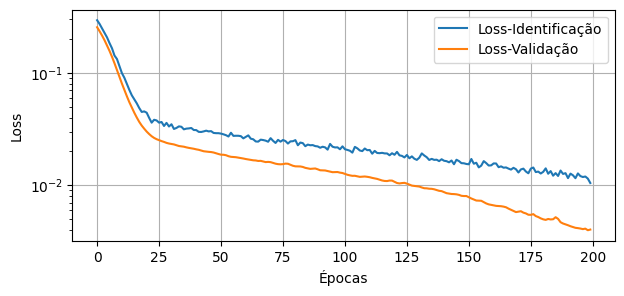

In [ ]:
# Plot loss
plt.figure(figsize=(7,3))
plt.semilogy(DadosTreino.history['loss'],label='Loss-Identificação')
plt.semilogy(DadosTreino.history['val_loss'],label='Loss-Validação')
plt.xlabel('Épocas'); plt.ylabel('Loss')
# plt.savefig('FOPDT_loss.png')
plt.grid()
plt.legend()
plt.show()

In [ ]:
# Salvando o modelo:
model.save('model.h5')

40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


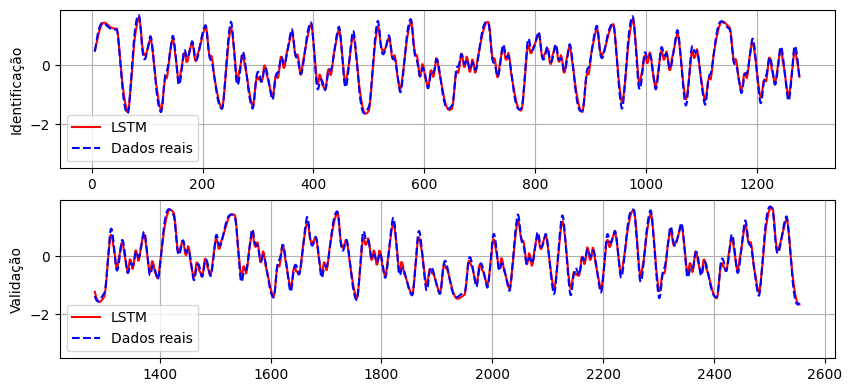

In [ ]:
# Verify the fit of the model
Yp_train = model.predict(X_train)
Yp_val = model.predict(X_val)

# un-scale outputs
Yu_train = Escala2.inverse_transform(Yp_train)
Ym_train = Escala2.inverse_transform(Y_train)

Yu_val = Escala2.inverse_transform(Yp_val)
Ym_val = Escala2.inverse_transform(Y_val)

plt.figure(0, figsize=(10,7))
plt.subplot(311)
plt.plot(Dados.index[atrasos:Ni],Yu_train[:,0],'r-',label='LSTM')
plt.plot(Dados.index[atrasos:Ni],Ym_train[:,0],'b--',label='Dados reais')
plt.ylabel('Identificação')
plt.legend(loc="lower left")
plt.ylim(-3.5,1.9)
plt.grid()
plt.subplot(312)
plt.plot(Dados.index[Ni+atrasos:],Yu_val[:,0],'r-',label='LSTM')
plt.plot(Dados.index[Ni+atrasos:],Ym_val[:,0],'b--',label='Dados reais')
plt.ylabel('Validação')
plt.legend(loc="lower left")
plt.ylim(-3.5,1.9)
plt.legend()
plt.grid()
plt.show()
# plt.subplot(313)
# plt.plot(Dados.index[Ni+atrasos:],np.abs(Yu_val[:,0]-Ym_val[:,0]),'r-',label='LSTM')
# # plt.plot(Dados.index[Ni+atrasos:],Ym_val[:,0],'b--',label='Dados reais')
# plt.ylabel('Validação')
# plt.legend(loc="lower left")
# plt.ylim(-3.5,1.9)
# plt.legend()
# plt.grid()
# plt.show()

In [ ]:
X_val.shape
Yp_val = model.predict(X_val[0:1,:,:])
print(Yp_val[0])
print(Y_train[0])
# X_val[0:2,:,:]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
[-0.7466818]
[0.26601656]
